In [44]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

from sigcorr.config import CFG
from sigcorr.tools.visual import set_plt_reasonable_defaults

from sigcorr.tools.utils import get_last_from_iter
from sigcorr.tools.utils import shape_to_line_index

from sigcorr.mapreduce.gp import gp_batch_mapreduce
from sigcorr.mapreduce.file import h5_batch_mapreduce

from sigcorr.mapreduce.map_reducers import EulerNumberCalc
from sigcorr.mapreduce.map_reducers import UpcrossCalc
from sigcorr.mapreduce.map_reducers import TestStatisticCalc
from sigcorr.mapreduce.map_reducers import SigsCalc
from sigcorr.mapreduce.map_reducers import MathCalc
from sigcorr.mapreduce.map_reducers import ChainCalc
from sigcorr.mapreduce.map_reducers import BatchStats1Reduce
from sigcorr.mapreduce.map_reducers import BatchStats2Reduce

from sigcorr.models.gross_vitells import GrossVitells
from sigcorr.models.gross_vitells_asimov import GrossVitellsAsimov
from sigcorr.models.hyy import Hyy
from sigcorr.models.hyy_asimov import HyyAsimov
from sigcorr.models.hyy_2d import Hyy2D
from sigcorr.models.hyy_2d_asimov import Hyy2DAsimov
from sigcorr.models.utils import set_params_from_file


CFG.FITTER.bfit_pool_size = 30  # gp draws use this pool size

set_plt_reasonable_defaults(plt)

In [22]:
#input_file = "../../output/hyy-1m.h5"
input_file = "../../output/gross_vitells-1m.h5"
#input_file = "../../output/hyy2d-2560.h5"
asimov_input_file = input_file.split("-")[0]+"-asimov.h5"

In [23]:
true_model = GrossVitells(None)
#true_model = Hyy(None)
#true_model = Hyy2D(None)
set_params_from_file(true_model, input_file)
true_model.init()

In [24]:
true_res_part = {}
with h5py.File(input_file, "r", swmr=True) as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs"]:
        true_res_part[field] = f[field][:10_000, ...]

In [26]:
asimov_model = GrossVitellsAsimov(None)
#asimov_model = HyyAsimov(true_model.xs)
#asimov_model = Hyy2DAsimov(true_model.xs)
set_params_from_file(asimov_model, asimov_input_file)
asimov_model.init()

In [27]:
asimov_res = {}
with h5py.File(input_file.split("-")[0] + "-asimov.h5", "r") as f:
    for field in ["b_loglikes", "sb_loglikes", "sb_params", "sb_params_vars", "bg_samples", "sb_successes", "b_successes", "scan_xs"]:
        asimov_res[field] = f[field][...]

In [28]:
asimov_samples = asimov_res["bg_samples"]

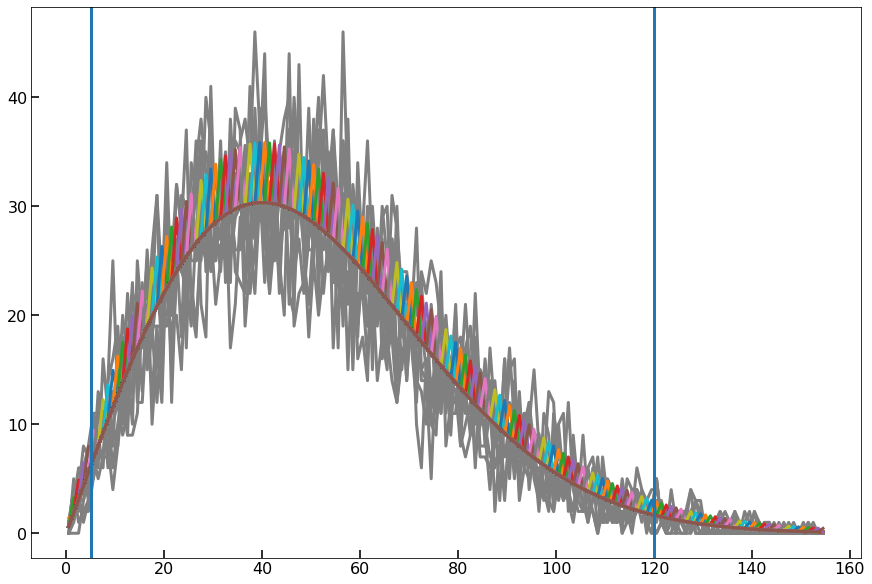

In [30]:
#plt.plot(true_model.xs, true_model.expected_b(true_model.B0, true_model.BG_XSCALE))  # Hyy, Hyy2D
plt.plot(true_model.xs, true_model.expected_b(true_model.B0))  # GrossVitells
plt.plot(true_model.xs, true_res_part["bg_samples"][:10].T, color="gray");
plt.plot(true_model.xs, asimov_samples.T);

# Hyy, GrossVitells
plt.axvline(true_res_part["scan_xs"][0])
plt.axvline(true_res_part["scan_xs"][-1])

# Hyy2D
#plt.axvline(true_res_part["scan_xs"][0, 0, 0])
#plt.axvline(true_res_part["scan_xs"][-1, 0, 0])

In [31]:
true_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
true_cov, true_cov_err = true_covcalc.get_cov(), true_covcalc.get_cov_stat_err()
true_corr, true_corr_err = true_covcalc.get_corr(), true_covcalc.get_corr_stat_err()

100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:25<00:00, 39308.69it/s]


In [32]:
asimov_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(asimov_input_file, ["b_loglikes", "sb_loglikes", "sb_params"], 10_000, SigsCalc(), BatchStats2Reduce()))
asimov_cov, asimov_cov_err = asimov_covcalc.get_cov(override_x=np.array(0)), asimov_covcalc.get_cov_stat_err(override_x=np.array(0))
asimov_corr, asimov_corr_err = asimov_covcalc.get_corr(override_x=np.array(0)), asimov_covcalc.get_corr_stat_err(override_x=np.array(0))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 272690.30it/s]


In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 8))
m = ax[0].imshow(true_corr, origin="upper")
plt.colorbar(mappable=m, ax=ax[0])
ax[0].set_title("brute force")
m = ax[1].imshow(asimov_corr, origin="upper")
plt.colorbar(mappable=m, ax=ax[1])
ax[1].set_title("asimov");
# m = ax[1].imshow(true_corr, origin="lower")
# plt.colorbar(mappable=m, ax=ax[1])
# ax[1].set_title("true");
#fig.savefig("figures/corrmat_brute_vs_asimov.png")

In [49]:
c0 = 0.7
c0 = 1/np.sqrt(2)

In [50]:
asimov_gp_euler_number_covcalc, _ = get_last_from_iter(gp_batch_mapreduce(asimov_corr, 3_000_000, 10000, true_res_part["scan_xs"].shape[:-1], ChainCalc([MathCalc(np.square), UpcrossCalc(c0**2)]), BatchStats1Reduce()))
asimov_gp_euler_number, asimov_gp_euler_number_err = asimov_gp_euler_number_covcalc.get_mean(), asimov_gp_euler_number_covcalc.get_stat_err()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3000000/3000000 [00:08<00:00, 366847.71it/s]


In [51]:
print(f"{asimov_gp_euler_number[0]} ± {asimov_gp_euler_number_err[0]} — {true_model.__class__.__name__} asimov gp [{asimov_gp_euler_number_covcalc.n} samples]")

4.363370666666667 ± 0.002607119248029143 — GrossVitells asimov gp [3000000 samples]


In [52]:
true_euler_number_covcalc, _ = get_last_from_iter(h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 10000, ChainCalc([TestStatisticCalc(), UpcrossCalc(c0**2)]), BatchStats1Reduce()))
true_euler_number, true_euler_number_err = true_euler_number_covcalc.get_mean(), true_euler_number_covcalc.get_stat_err(override_x=None)

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 1346960.39it/s]


In [53]:
print(f"{true_euler_number[0]} ± {true_euler_number_err[0]} — {true_model.__class__.__name__} toys [{true_euler_number_covcalc.n} samples]")

4.379092999999998 ± 0.004531159434796407 — GrossVitells toys [1000000 samples]


In [54]:
print(f"{asimov_gp_euler_number/true_euler_number} ± {asimov_gp_euler_number_err/true_euler_number + asimov_gp_euler_number/true_euler_number**2*true_euler_number_err} — asimov/{true_model.__class__.__name__}")

[0.99640968] ± [0.00162637] — asimov/GrossVitells


In [57]:
def get_running_euler_number(input_file, c0):
    cum_mean = []
    cum_err = []
    xs = []
    for partial_covcalc, partial_num in h5_batch_mapreduce(input_file, ["b_loglikes", "sb_loglikes"], 10000, ChainCalc([TestStatisticCalc(), UpcrossCalc(c0**2)]), BatchStats1Reduce()):
        euler_number_mean = partial_covcalc.get_mean()*partial_covcalc.n/partial_num
        cum_mean.append(euler_number_mean)
        euler_number_err = partial_covcalc.get_stat_err()*partial_covcalc.n/partial_num
        cum_err.append(euler_number_err)
        xs.append(partial_num)
    xs = np.asarray(xs)
    cum_mean = np.asarray(cum_mean)
    cum_err = np.asarray(cum_err)
    plt.plot(xs, cum_mean, color="black", label="true euler_number")
    plt.plot(xs, cum_mean + cum_err, color="orange", label="1σ true euler_number")
    plt.plot(xs, cum_mean - cum_err, color="orange")
#plt.ylim([3.2, 3.3])
get_running_euler_number(input_file, c0)
plt.axhline(asimov_gp_euler_number, color="red", label="asimov")
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:00<00:00, 1113508.29it/s]


In [56]:
plt.axhline(0, color="gray", ls="--")
plt.errorbar(list(shape_to_line_index(true_res_part["scan_xs"].shape)), true_covcalc.get_mean(), yerr=true_covcalc.get_stat_err(), capsize=2, elinewidth=0, label="mean toy significance")
plt.errorbar(list(shape_to_line_index(true_res_part["scan_xs"].shape)), asimov_covcalc.get_mean(), yerr=asimov_covcalc.get_stat_err(), capsize=2, elinewidth=0, label="mean asimov significance")
plt.legend()